In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [48]:
class Likelihood(nn.Module):
    def __init__(self):
        super().__init__()
        # Parameters for line
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Noise of data
        self.noise = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Collect losses over time
        self.losses = []
    
    def forward(self, x, y):
        # Takes numpy array as input and converts to tensors
        x = torch.tensor(x)
        y = torch.tensor(y)
        
        # Minimizing this function
        loss = -torch.log(self.noise) - torch.sum((y - x * self.m - self.b) ** 2 / (2 * self.noise ** 2))
        #loss = -0.5 * torch.log(2 * np.pi * self.noise ** 2) - ((y - (self.b + self.m * x)) ** 2) / (2 * self.noise ** 2)
        
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [49]:
def train(model, x, y, epochs=5, frac=0.1):
    optimizer = optim.Adam(model.parameters())
    
    for epoch in tqdm(range(epochs), desc="Training..."):
        # Zeros gradiant for training
        optimizer.zero_grad()
        
        # Random selection of data points per iteration
        indices = np.random.randint(low=0, high=len(x), size=int(len(x) * frac))
        
        # Calculates likelihood
        loglik = model(x[indices], y[indices])
        #loglik = model(x, y)
        
        # Mean of loglik
        e = -torch.mean(loglik)
        
        # Updates parameters
        e.backward()
        optimizer.step()
        
    return model

In [50]:
df = pd.read_csv('data/Advertising.csv').drop('Unnamed: 0', axis=1)
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [51]:
x = df.TV.to_numpy()
y = df.Sales.to_numpy()

In [52]:
m_ll = train(Likelihood(), x, y, epochs=100000, frac=0.1)
m_ll

Training...: 100%|██████████| 100000/100000 [00:32<00:00, 3058.64it/s]


Likelihood()

In [53]:
(m_ll.m, m_ll.b, m_ll.noise)

(Parameter containing:
 tensor(0.0476, requires_grad=True),
 Parameter containing:
 tensor(7.0351, requires_grad=True),
 Parameter containing:
 tensor(14.5397, requires_grad=True))

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Likelihood Loss')]

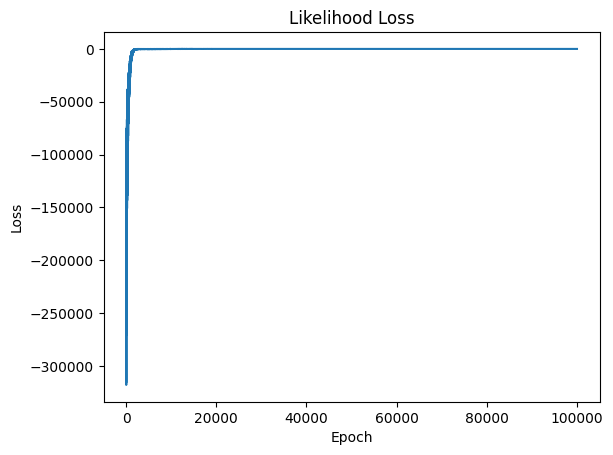

In [54]:
fig = sns.lineplot(x=range(len(m_ll.losses)), y=m_ll.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Likelihood Loss')

In [55]:
class SimpleProb(nn.Module):
    def __init__(self):
        super().__init__()
        self.std = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Collects loss over time
        self.losses = []
    
    def forward(self, k):
        loss = torch.log(self.std) + 0.5 * (k / self.std) ** 2
    
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [56]:
class Posterior(nn.Module):
    def __init__(self):
        # All parameters that need optimization
        super().__init__()
        self.ll = Likelihood()
        self.pm = SimpleProb()
        self.pb = SimpleProb()
        
        # Collects loss over time
        self.losses = []
        self.reses = []
    
    def forward(self, x, y):
        loss = self.ll(x, y) + self.pm(self.ll.m) + self.pb(self.ll.b)
                
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [57]:
m_p = train(Posterior(), x, y, epochs=100000, frac=0.1)
m_p

Training...: 100%|██████████| 100000/100000 [00:51<00:00, 1955.76it/s]


Posterior(
  (ll): Likelihood()
  (pm): SimpleProb()
  (pb): SimpleProb()
)

In [58]:
(m_p.ll.m, m_p.pm.std, m_p.ll.b, m_p.pb.std, m_p.ll.noise)

(Parameter containing:
 tensor(0.0464, requires_grad=True),
 Parameter containing:
 tensor(97.2717, requires_grad=True),
 Parameter containing:
 tensor(7.0407, requires_grad=True),
 Parameter containing:
 tensor(97.2572, requires_grad=True),
 Parameter containing:
 tensor(14.5153, requires_grad=True))

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Posterior Loss')]

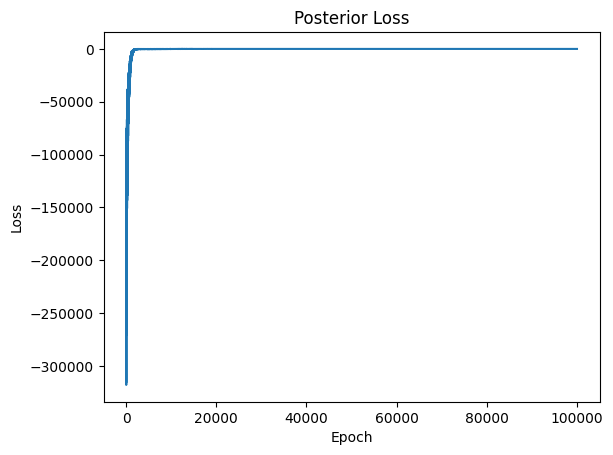

In [59]:
fig = sns.lineplot(x=range(len(m_p.losses)), y=m_ll.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Posterior Loss')